# Machine learning model to predict observer intensity using DASK

Here we need a model to predict observer intensity of developing regions.
- First we train a machine learning model on developed regions dataset and test the model within this dataset using DASK library for Random forest and MLP algorithms. 
- Then we choose the model with better function and tune the the hyperparameters of the model to reach the best model
- Finally we apply our model on developing regions to predict the potential regions for observers.

## 1. Train a regression model using DASK on Developed regions dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read developed regions dataset from crib using pandas 
df = pd.read_csv('0_data/developed_2017stall.csv')
df

,Unnamed: 0,block,obsdate,nb_observers,nb_observations,nb_species,doy,dow,holiday,precip,temper,longit,latit,geom,urlnr,aves2012_2016,pop001,roads_nowater_length,ndvi
0,11385,1354,2017-01-01,3,9,6,1,0,True,5.057450,1.93304,42,411,0103000020407100000100000005000000000000000082...,631501,160,5,645.26066,0.607853
1,11386,1354,2017-01-02,3,28,18,2,1,False,1.317730,6.99588,42,411,0103000020407100000100000005000000000000000082...,631501,160,5,645.26066,0.607853
2,11387,1354,2017-01-03,5,7,3,3,2,False,1.411040,6.53653,42,411,0103000020407100000100000005000000000000000082...,631501,160,5,645.26066,0.607853
3,11388,1354,2017-01-04,4,6,5,4,3,False,1.176680,7.64293,42,411,0103000020407100000100000005000000000000000082...,631501,160,5,645.26066,0.607853
4,11389,1354,2017-01-05,12,55,14,5,4,False,0.000000,5.13298,42,411,0103000020407100000100000005000000000000000082...,631501,160,5,645.26066,0.607853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89919,445879,39652,2017-06-08,1,5,5,159,4,False,0.569949,21.20340,243,574,010300002040710000010000000500000000000000C0A9...,39652,144,410,4831.28738,0.494527
89920,445880,39652,2017-06-10,2,6,3,161,6,False,0.000000,21.89960,243,574,010300002040710000010000000500000000000000C0A9...,39652,144,410,4831.28738,0.494527
89921,445881,39652,2017-06-14,1,3,2,165,3,False,0.000000,22.82750,243,574,010300002040710000010000000500000000000000C0A9...,39652,144,410,4831.28738,0.494527
89922,445882,39652,2017-06-20,1,7,7,171,2,False,0.000000,20.77310,243,574,010300002040710000010000000500000000000000C0A9...,39652,144,410,4831.28738,0.494527


### Normalize data
There are different units and scales in the variables of the dataset. To get more precise result for modelling, we normalize the variables with different units. 

In [3]:
dataset_norm = pd.DataFrame()
for (colname, coldata) in df.iteritems():
    if colname == 'block' \
    or colname == 'obsdate' \
    or colname == 'nb_observers' \
    or colname == 'nb_observations' \
    or colname == 'nb_species' \
    or colname == 'doy' \
    or colname == 'dow'\
    or colname == 'holiday'\
    or colname == 'longit'\
    or colname == 'latit'\
    or colname == 'geom'\
    or colname == 'urlnr':
        dataset_norm[colname] = df[colname]
    else:
         dataset_norm[colname] = (df[colname] - df[colname].mean()) / (df[colname].max() - df[colname].min())
dataset_norm.head()

,Unnamed: 0,block,obsdate,nb_observers,nb_observations,nb_species,doy,dow,holiday,precip,temper,longit,latit,geom,urlnr,aves2012_2016,pop001,roads_nowater_length,ndvi
0,-0.334375,1354,2017-01-01,3,9,6,1,0,True,0.104766,-0.315760,42,411,0103000020407100000100000005000000000000000082...,631501,0.180758,-0.066225,-0.18647,0.181382
1,-0.334373,1354,2017-01-02,3,28,18,2,1,False,-0.006017,-0.172159,42,411,0103000020407100000100000005000000000000000082...,631501,0.180758,-0.066225,-0.18647,0.181382
2,-0.334371,1354,2017-01-03,5,7,3,3,2,False,-0.003253,-0.185188,42,411,0103000020407100000100000005000000000000000082...,631501,0.180758,-0.066225,-0.18647,0.181382
3,-0.334368,1354,2017-01-04,4,6,5,4,3,False,-0.010196,-0.153806,42,411,0103000020407100000100000005000000000000000082...,631501,0.180758,-0.066225,-0.18647,0.181382
4,-0.334366,1354,2017-01-05,12,55,14,5,4,False,-0.045053,-0.224998,42,411,0103000020407100000100000005000000000000000082...,631501,0.180758,-0.066225,-0.18647,0.181382


In [4]:
# Transform dataset to Dask dataframe to be used well in modelling large data with DASK library
import dask.dataframe as dd
dataset = dd.from_pandas(dataset_norm, npartitions=10)
dataset 

,Unnamed: 0,block,obsdate,nb_observers,nb_observations,nb_species,doy,dow,holiday,precip,temper,longit,latit,geom,urlnr,aves2012_2016,pop001,roads_nowater_length,ndvi
npartitions=10,,,,,,,,,,,,,,,,,,,
0,float64,int64,object,int64,int64,int64,int64,int64,bool,float64,float64,int64,int64,object,int64,float64,float64,float64,float64
8993,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80932,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89923,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
# Select independent variables from dataset for prediction model 
Predictors = ['precip', 'temper', 'roads_nowater_length', 'ndvi', 'longit', 'latit', 'pop001', 'doy', 'dow']

### Implementing regression model using DASK

In [6]:
from dask.distributed import Client
client = Client()

In [7]:
# Define dependent variables(Y) and independent variables(X) for modelling developed dataset in DASK
Y = dataset['nb_observers']
X = dataset[Predictors]

In [8]:
# Split the dataset for training (70%) and testing (30%)
import dask_ml.model_selection as ms
Xtrain, Xtest, ytrain, ytest = ms.train_test_split(X, Y, test_size=0.3, random_state=42)

/usr/local/lib/python3.8/dist-packages/dask_ml/model_selection/_split.py:462: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


In [9]:
# Scale developed dataset and fit the scaler to training data and then transform both training and test data with the same fitted scaler
import dask_ml.preprocessing as pr
scaler = pr.StandardScaler()
scaler.fit(Xtrain)

Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from joblib import parallel_backend
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [11]:
# Train the regressor using MLP algorithm
mlp = MLPRegressor()

with parallel_backend('dask'):
    mlp.fit(Xtrain, ytrain)    # fit the model on the traning set
    y_mlp = mlp.predict(Xtest) # Predict observer intensity on testing set



/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [12]:
# Train the regressor using Random forest algorithm
rf = RandomForestRegressor(oob_score = True)

with parallel_backend('dask'):
    rf.fit(Xtrain, ytrain)
    y_rf = rf.predict(Xtest)

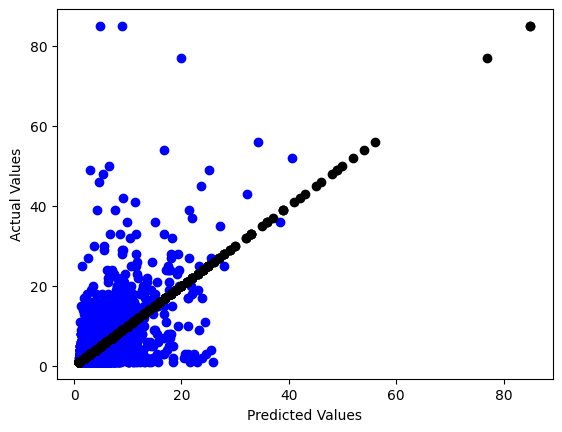

In [13]:
# Visualize the predicted values from model and actual values from testing set
plt.scatter(y_rf, ytest,c='b')
plt.scatter(ytest, ytest,c='k')
#plt.title('Scatter plot')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [14]:
# Evaluate the default mlp Model by calculating R^2
mlp.score(Xtest, ytest)

0.12383440866613782

In [15]:
# Evaluate the default random forest Model by calculating R^2
score_default = rf.score(Xtest, ytest)
score_default

0.3719487624776078

In [16]:
rf_mean_squared_error = mean_squared_error(ytest, y_rf)
rf_mean_squared_error

3.8930675410078317

In [17]:
rf.feature_importances_

array([0.10140387, 0.23042164, 0.1125228 , 0.08628399, 0.06646722,
       0.09191873, 0.04261737, 0.19652333, 0.07184105])

## 2.  Hyperparameter optimization of the default model with scikit-learn

After training model with two algorithms, the results show that random forest algorithm works better for this dataset. So, we just optimize hyperparameters for this model using randomized research technique.

In [18]:
## Define dependent variables(Y) and independent variables(X) for modelling in scikit-learn
from sklearn.model_selection import train_test_split
Y1 = dataset_norm['nb_observers']
X1 = dataset_norm[Predictors]
# Split the dataset for training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.3, random_state=42)

In [19]:
from scipy.stats import randint as sp_randint

In [20]:
# specify parameters and distributions to sample from
# Setting the random grid for the cross validation

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 100)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = sp_randint(2, 11)

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random search parameters
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


In [21]:
from sklearn.model_selection import RandomizedSearchCV
from time import time
# Creating the base model for tunning
rf = RandomForestRegressor()

# run randomized search using 5 fold cross validation and 20 combinations
n_iter_search = 20
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)

start = time()

with parallel_backend('dask'):
    random_search.fit(X_train, y_train)
    
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

#random_search.best_params_

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors an

RandomizedSearchCV took 427.65 seconds for 20 candidates parameter settings.


In [22]:
# The best random parameters
print('The best parameters: ')
random_search.best_params_

The best parameters: 


{'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 396}

In [23]:
# Train the model with optimized parameters
best_model = random_search.best_estimator_

with parallel_backend('dask'):
    best_model.fit(Xtrain, ytrain)
    ypred_best = best_model.predict(Xtest)

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [24]:
# Evaluate the optimized random forest Model by calculating R^2
score_optimized = best_model.score(Xtest, ytest)
score_optimized

0.38126275413215416

In [25]:
# Calculate final model improvement
improvement = 100 * (score_optimized - score_default) / score_default
print('improvement: ', round(improvement, 2), '%' )

improvement:  2.5 %


In [26]:
opt_rf_mean_squared_error = mean_squared_error(ytest, ypred_best)
opt_rf_mean_squared_error

3.8353334001906347

## 3. Apply optimized model on developing regions dataset for prediction

In [27]:
# Read developing regions dataset from crib using pandas 
df_developing = pd.read_csv('0_data/developing_2017stall.csv')

In [28]:
# Normaliz developing dataset
dataset_norm_developing = pd.DataFrame()
for (colname, coldata) in df_developing.iteritems():
    if colname == 'block' \
    or colname == 'obsdate' \
    or colname == 'nb_observers' \
    or colname == 'nb_observations' \
    or colname == 'nb_species' \
    or colname == 'doy' \
    or colname == 'dow'\
    or colname == 'holiday'\
    or colname == 'longit'\
    or colname == 'latit'\
    or colname == 'geom'\
    or colname == 'urlnr':
        dataset_norm_developing[colname] = df_developing[colname]
    else:
         dataset_norm_developing[colname] = (df_developing[colname] - df_developing[colname].mean()) / (df_developing[colname].max() - df_developing[colname].min())

In [29]:
# Transform developing dataset to Dask dataframe to be used well in modelling large data with DASK library
import dask.dataframe as dd
dataset_developing = dd.from_pandas(dataset_norm_developing, npartitions=10) 

In [30]:
# Define dependent variables(Y) and independent variables(X) for modelling developing dataset in DASK
Y_developing = dataset_developing['nb_observers']
X_developing = dataset_developing[Predictors]

In [31]:
# Scale predictors of the developing datasetthe same fitted scaler of the trained model on developed dataset
X_developing = scaler.transform(X_developing)

In [32]:
# Predict observer intensity in developing regions using optimized model
with parallel_backend('dask'):
    ypred_developing = best_model.predict(X_developing)

In [33]:
# Evaluate the prediction of developing regions by calculating R^2
best_model.score(X_developing, Y_developing)

-2.0011871621535584

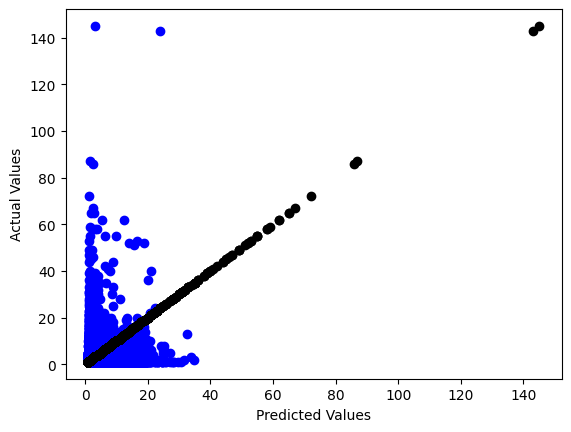

In [34]:
# Visualize the predicted values from model and actual values from developing dataset
plt.scatter(ypred_developing, Y_developing,c='b')
plt.scatter(Y_developing, Y_developing,c='k')
#plt.title('Scatter plot')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [35]:
best_model.feature_importances_

array([0.08917285, 0.19817667, 0.12163303, 0.09677191, 0.07444176,
       0.10486225, 0.04569461, 0.19843233, 0.07081459])

Save predict results.

In [36]:
import csv
dataout_path = '0_data/'

developingresult_file = dataout_path + 'developing_2017pred.csv' 
csv_header = [" ", "pred_nb_observers"]
with open (developingresult_file, "w", newline = '') as developingresult_data:
    developingresult_csv = csv.writer(developingresult_data)
    developingresult_csv.writerow(csv_header)
    for i in range(len(ypred_developing)):
        developingresult_writerow = [i, ypred_developing[i]]
        developingresult_csv.writerow(developingresult_writerow)

In [ ]:
_